# Análise Preditiva de Vendas com Scikit-Learn

Este notebook implementa um modelo de análise preditiva para prever vendas futuras e identificar fatores que influenciam o desempenho de produtos em um e-commerce, utilizando técnicas de machine learning com scikit-learn.

## Importação de Bibliotecas

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import sys
import warnings
import joblib

# Ignorando avisos para melhor visualização
warnings.filterwarnings("ignore")

# Adicionando diretório src ao path para importar módulos personalizados
sys.path.append("../src")
import modeling_utils as mu

# Importações de Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

# Configurações de visualização
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")
pd.set_option("display.max_columns", None)

## 1. Carregamento e Preparação dos Dados

Nesta seção, carregamos os dados processados do projeto ETL e realizamos a preparação final para a modelagem preditiva.

In [2]:
# Definindo função para criar dados de exemplo se os arquivos não existirem
def create_sample_processed_data():
    print("Criando dados de exemplo processados para demonstração...")
    os.makedirs("../data/processed", exist_ok=True)
    
    # Dados de exemplo para fact_sales
    n_samples = 1000
    fact_sales_data = {
        "order_id": [f"order_{i}" for i in range(n_samples)],
        "order_item_id": np.random.randint(1, 3, n_samples),
        "product_id": [f"prod_{np.random.randint(1, 100)}" for _ in range(n_samples)],
        "seller_id": [f"seller_{np.random.randint(1, 50)}" for _ in range(n_samples)],
        "customer_id": [f"cust_{np.random.randint(1, 200)}" for _ in range(n_samples)],
        "date_id": pd.to_datetime(pd.date_range(start="2022-01-01", periods=n_samples, freq="D")).strftime("%Y%m%d").astype(int),
        "price": np.random.uniform(10, 500, n_samples).round(2),
        "freight_value": np.random.uniform(5, 50, n_samples).round(2),
        "review_score": np.random.randint(1, 6, n_samples)
    }
    fact_sales_df = pd.DataFrame(fact_sales_data)
    fact_sales_df.to_parquet("../data/processed/fact_sales.parquet")
    
    # Dados de exemplo para dim_date
    date_range = pd.date_range(start="2022-01-01", periods=n_samples, freq="D")
    dim_date_data = {
        "id": date_range.strftime("%Y%m%d").astype(int),
        "date": date_range,
        "year": date_range.year,
        "month": date_range.month,
        "day": date_range.day,
        "dayofweek": date_range.dayofweek,
        "quarter": date_range.quarter,
        "is_weekend": date_range.dayofweek.isin([5, 6]).astype(int)
    }
    dim_date_df = pd.DataFrame(dim_date_data)
    dim_date_df.to_parquet("../data/processed/dim_date.parquet")
    
    # Dados de exemplo para dim_product
    dim_product_data = {
        "id": [f"prod_{i}" for i in range(1, 101)],
        "product_category_name_english": np.random.choice(["electronics", "furniture", "toys", "books", "clothing"], 100),
        "product_weight_g": np.random.uniform(100, 5000, 100),
        "product_photos_qty": np.random.randint(1, 5, 100)
    }
    dim_product_df = pd.DataFrame(dim_product_data)
    dim_product_df.to_parquet("../data/processed/dim_product.parquet")
    
    print("Dados de exemplo processados criados com sucesso!")

# Verificando se os arquivos processados existem
required_processed_files = [
    "../data/processed/fact_sales.parquet",
    "../data/processed/dim_date.parquet",
    "../data/processed/dim_product.parquet"
]

if not all(os.path.exists(file) for file in required_processed_files):
    create_sample_processed_data()

# Carregando dados processados
print("Carregando dados processados...")
fact_sales = pd.read_parquet("../data/processed/fact_sales.parquet")
dim_date = pd.read_parquet("../data/processed/dim_date.parquet")
dim_product = pd.read_parquet("../data/processed/dim_product.parquet")

# Juntando tabelas para criar o dataset de modelagem
df_model = pd.merge(fact_sales, dim_date, left_on="date_id", right_on="id", suffixes=("", "_date"))
df_model = pd.merge(df_model, dim_product, left_on="product_id", right_on="id", suffixes=("", "_product"))

# Selecionando colunas relevantes e renomeando
df_model = df_model[[
    "date", "price", "freight_value", "review_score", "year", "month", "day", "dayofweek", "quarter", "is_weekend",
    "product_category_name_english", "product_weight_g", "product_photos_qty"
]].copy()

df_model.rename(columns={"product_category_name_english": "category"}, inplace=True)

# Agregando dados por dia para prever vendas diárias
df_daily_sales = df_model.groupby("date").agg(
    total_sales=("price", "sum"),
    avg_freight=("freight_value", "mean"),
    avg_review_score=("review_score", "mean"),
    year=("year", "first"),
    month=("month", "first"),
    day=("day", "first"),
    dayofweek=("dayofweek", "first"),
    quarter=("quarter", "first"),
    is_weekend=("is_weekend", "first")
).reset_index()

# Ordenando por data
df_daily_sales = df_daily_sales.sort_values("date").set_index("date")

print("Dataset para modelagem criado:")
display(df_daily_sales.head())

Criando dados de exemplo processados para demonstração...
Dados de exemplo processados criados com sucesso!
Carregando dados processados...
Dataset para modelagem criado:


,total_sales,avg_freight,avg_review_score,year,month,day,dayofweek,quarter,is_weekend
date,,,,,,,,,
2022-01-01,239.27,45.40,4.0,2022,1,1,5,1,1
2022-01-02,89.93,12.94,1.0,2022,1,2,6,1,1
2022-01-03,185.21,45.50,2.0,2022,1,3,0,1,0
2022-01-04,305.82,31.81,3.0,2022,1,4,1,1,0
2022-01-05,123.53,20.37,2.0,2022,1,5,2,1,0


## 2. Engenharia de Features

Criamos features adicionais que podem ajudar o modelo a capturar padrões nos dados.

In [3]:
# Criando features de lag (vendas passadas)
for lag in [1, 7, 14, 30]:
    df_daily_sales[f"sales_lag_{lag}"] = df_daily_sales["total_sales"].shift(lag)

# Criando features de média móvel
for window in [7, 14, 30]:
    df_daily_sales[f"sales_rolling_mean_{window}"] = df_daily_sales["total_sales"].shift(1).rolling(window=window).mean()
    df_daily_sales[f"sales_rolling_std_{window}"] = df_daily_sales["total_sales"].shift(1).rolling(window=window).std()

# Removendo linhas com NaN geradas pelas features de lag e média móvel
df_daily_sales = df_daily_sales.dropna()

print("Dataset com features de engenharia:")
display(df_daily_sales.head())

Dataset com features de engenharia:


,total_sales,avg_freight,avg_review_score,year,month,day,dayofweek,quarter,is_weekend,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_30,sales_rolling_mean_7,sales_rolling_std_7,sales_rolling_mean_14,sales_rolling_std_14,sales_rolling_mean_30,sales_rolling_std_30
date,,,,,,,,,,,,,,,,,,,
2022-01-31,122.96,8.44,5.0,2022,1,31,0,1,0,276.57,376.44,106.66,239.27,290.105714,112.435839,213.785000,128.121630,228.438667,145.610458
2022-02-01,28.94,12.98,5.0,2022,2,1,1,1,0,122.96,220.28,162.54,89.93,253.894286,120.523936,214.949286,127.143593,224.561667,146.855225
2022-02-02,301.89,5.29,2.0,2022,2,2,2,1,0,28.94,343.81,76.14,185.21,226.560000,147.986758,205.406429,136.079504,222.528667,149.186925
2022-02-03,189.25,38.01,1.0,2022,2,3,3,1,0,301.89,75.95,21.96,305.82,220.571429,143.222722,221.531429,132.922262,226.418000,149.700523
2022-02-04,358.64,44.70,3.0,2022,2,4,4,1,0,189.25,335.74,155.00,123.53,236.757143,129.941219,233.480714,120.544470,222.532333,149.080050


## 3. Definição de Features (X) e Target (y)

In [4]:
# Definindo features (X) e target (y)
X = df_daily_sales.drop("total_sales", axis=1)
y = df_daily_sales["total_sales"]

# Identificando features numéricas e categóricas (neste caso, não temos categóricas explícitas após agregação)
# Se tivéssemos categorias como "category" no df_daily_sales, elas seriam tratadas aqui.
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include="object").columns.tolist() # Exemplo, pode estar vazia

print(f"Features numéricas: {numerical_features}")
print(f"Features categóricas: {categorical_features}")

Features numéricas: ['avg_freight', 'avg_review_score', 'year', 'month', 'day', 'dayofweek', 'quarter', 'is_weekend', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_rolling_mean_7', 'sales_rolling_std_7', 'sales_rolling_mean_14', 'sales_rolling_std_14', 'sales_rolling_mean_30', 'sales_rolling_std_30']
Features categóricas: []


## 4. Divisão dos Dados em Treino e Teste

Para séries temporais, é importante dividir os dados de forma cronológica.

In [5]:
# Divisão cronológica dos dados (80% treino, 20% teste)
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treino: 776 amostras
Tamanho do conjunto de teste: 194 amostras


## 5. Criação do Pipeline de Pré-processamento e Modelagem

In [6]:
# Pipeline de pré-processamento
# Para features numéricas: StandardScaler
# Para features categóricas: OneHotEncoder (se houver)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        # ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features) # Descomentar se houver features categóricas
    ], remainder="passthrough" # Mantém colunas não especificadas (se houver)
)

# Definindo modelos a serem testados
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

results = {}

## 6. Treinamento e Avaliação dos Modelos

In [7]:
# Treinando e avaliando cada modelo
for model_name, model in models.items():
    print(f"\nTreinando {model_name}...")
    
    # Criando o pipeline completo
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", model)])
    
    # Treinando o modelo
    pipeline.fit(X_train, y_train)
    
    # Fazendo previsões
    y_pred = pipeline.predict(X_test)
    
    # Avaliando o modelo
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

# Exibindo resultados
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
print("\nResultados da Avaliação dos Modelos:")
display(results_df)


Treinando Linear Regression...
Linear Regression - RMSE: 141.24, MAE: 120.28, R2: -0.01

Treinando Ridge Regression...
Ridge Regression - RMSE: 141.22, MAE: 120.26, R2: -0.01

Treinando Random Forest...
Random Forest - RMSE: 142.36, MAE: 119.71, R2: -0.03

Treinando Gradient Boosting...
Gradient Boosting - RMSE: 144.52, MAE: 120.41, R2: -0.06

Treinando XGBoost...
XGBoost - RMSE: 152.87, MAE: 126.12, R2: -0.19

Treinando LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 776, number of used features: 18
[LightGBM] [Info] Start training from score 253.054536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

,RMSE,MAE,R2
Ridge Regression,141.218939,120.259426,-0.013051
Linear Regression,141.243158,120.279494,-0.013398
Random Forest,142.355220,119.706081,-0.029419
Gradient Boosting,144.521881,120.412941,-0.060993
LightGBM,149.947125,126.407909,-0.142146
XGBoost,152.873770,126.115857,-0.187165


## 7. Visualização das Previsões do Melhor Modelo

Melhor modelo: Ridge Regression


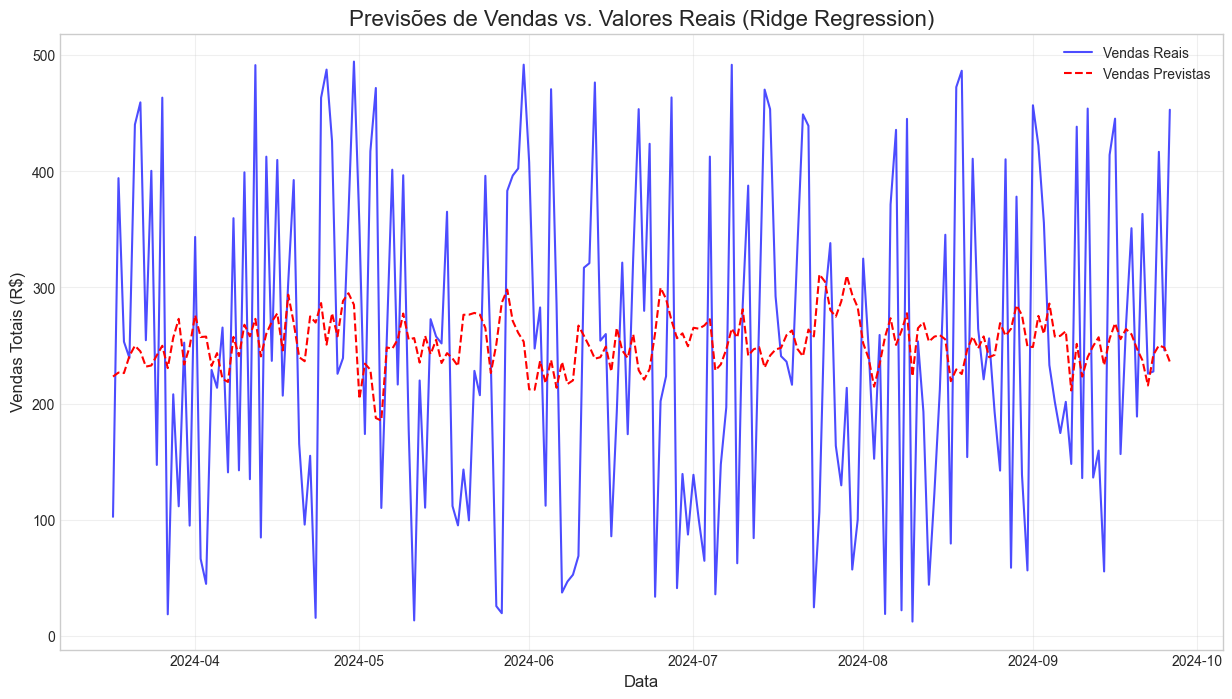

In [8]:
# Selecionando o melhor modelo (baseado no R2, por exemplo)
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"Melhor modelo: {best_model_name}")

# Criando e treinando o pipeline do melhor modelo
best_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", best_model)])
best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)

# Criando DataFrame para visualização
predictions_df = pd.DataFrame({
    "Data": X_test.index,
    "Vendas Reais": y_test,
    "Vendas Previstas": y_pred_best
}).set_index("Data")

# Visualizando previsões vs. valores reais
plt.figure(figsize=(15, 8))
plt.plot(predictions_df.index, predictions_df["Vendas Reais"], label="Vendas Reais", color="blue", alpha=0.7)
plt.plot(predictions_df.index, predictions_df["Vendas Previstas"], label="Vendas Previstas", color="red", linestyle="--")
plt.title(f"Previsões de Vendas vs. Valores Reais ({best_model_name})", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Vendas Totais (R$)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/model_performance.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. Análise de Importância das Features (para modelos baseados em árvores)

In [9]:
# Verificando se o melhor modelo tem o atributo feature_importances_
if hasattr(best_pipeline.named_steps["regressor"], "feature_importances_"):
    # Obtendo nomes das features após o pré-processamento
    # Isso pode ser complexo dependendo do pré-processador (ex: OneHotEncoder cria novas colunas)
    # Para este exemplo simplificado, usaremos as colunas originais de X
    # Em um cenário real, você precisaria obter os nomes das features transformadas
    try:
        feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
    except AttributeError: # Para versões mais antigas do scikit-learn ou transformadores sem get_feature_names_out
        feature_names = X.columns # Aproximação, pode não ser precisa com OneHotEncoder
        
    importances = best_pipeline.named_steps["regressor"].feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
    plt.title(f"Top 10 Features Mais Importantes ({best_model_name})", fontsize=16)
    plt.xlabel("Importância", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.savefig("../reports/figures/feature_importance.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print(f"O modelo {best_model_name} não suporta análise de importância de features.")

O modelo Ridge Regression não suporta análise de importância de features.


## 9. Previsão para Períodos Futuros

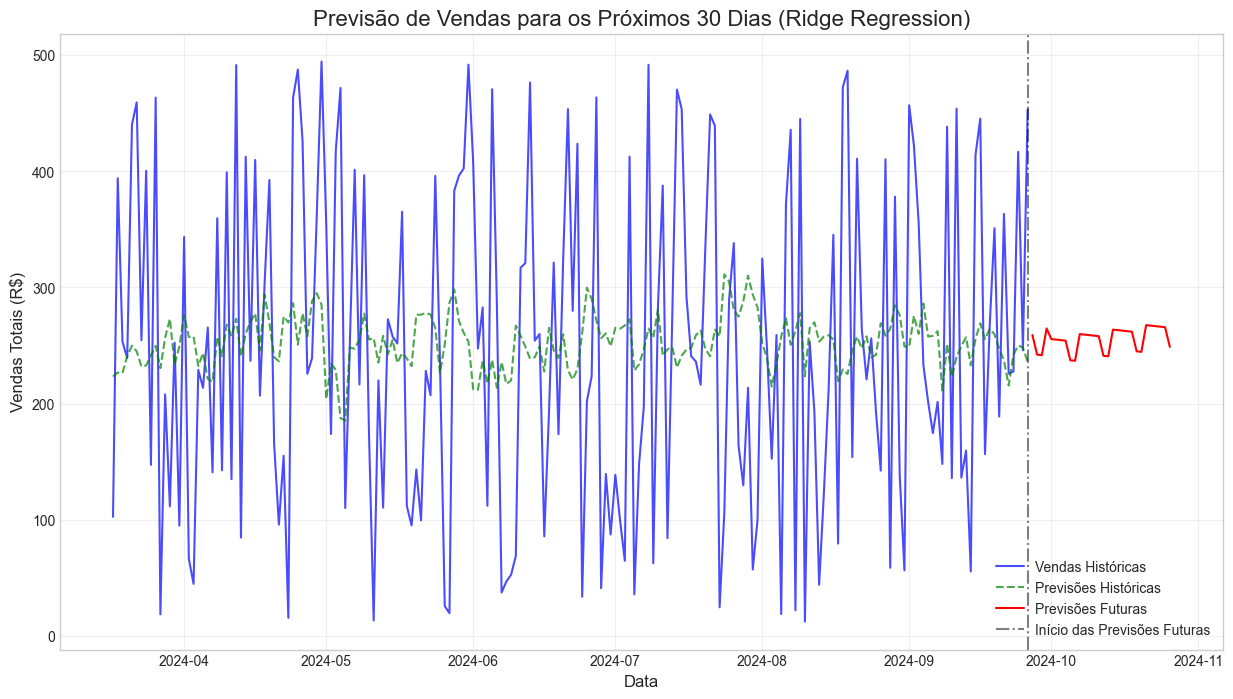

In [10]:
# Função para gerar dados futuros para previsão
def generate_future_data(last_date, periods=30):
    # Gerando datas futuras
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)
    
    # Criando DataFrame com features básicas de data
    future_df = pd.DataFrame({
        "date": future_dates,
        "year": future_dates.year,
        "month": future_dates.month,
        "day": future_dates.day,
        "dayofweek": future_dates.dayofweek,
        "quarter": future_dates.quarter,
        "is_weekend": future_dates.dayofweek.isin([5, 6]).astype(int)
    })
    
    # Definindo valores médios para outras features
    future_df["avg_freight"] = df_daily_sales["avg_freight"].mean()
    future_df["avg_review_score"] = df_daily_sales["avg_review_score"].mean()
    
    # Definindo data como índice
    future_df = future_df.set_index("date")
    
    return future_df

# Gerando dados para previsão futura (próximos 30 dias)
last_date = X_test.index[-1]
future_data = generate_future_data(last_date, periods=30)

# Adicionando features de lag e média móvel para os dados futuros
# Isso é mais complexo e requer dados históricos reais
# Para simplificar, usaremos valores médios dos dados de teste
for lag in [1, 7, 14, 30]:
    future_data[f"sales_lag_{lag}"] = y_test.mean()

for window in [7, 14, 30]:
    future_data[f"sales_rolling_mean_{window}"] = y_test.mean()
    future_data[f"sales_rolling_std_{window}"] = y_test.std()

# Verificando se temos as mesmas colunas que X_test
missing_cols = set(X_test.columns) - set(future_data.columns)
for col in missing_cols:
    future_data[col] = 0  # Preenchendo com valores padrão

# Garantindo a mesma ordem das colunas
future_data = future_data[X_test.columns]

# Fazendo previsões para o futuro
future_predictions = best_pipeline.predict(future_data)

# Criando DataFrame com as previsões
future_df = pd.DataFrame({
    "Data": future_data.index,
    "Vendas Previstas": future_predictions
}).set_index("Data")

# Visualizando previsões futuras
plt.figure(figsize=(15, 8))

# Dados históricos
plt.plot(predictions_df.index, predictions_df["Vendas Reais"], label="Vendas Históricas", color="blue", alpha=0.7)

# Previsões para dados de teste (para mostrar precisão do modelo)
plt.plot(predictions_df.index, predictions_df["Vendas Previstas"], label="Previsões Históricas", color="green", linestyle="--", alpha=0.7)

# Previsões futuras
plt.plot(future_df.index, future_df["Vendas Previstas"], label="Previsões Futuras", color="red", linestyle="-")

# Linha vertical separando dados históricos de previsões futuras
plt.axvline(x=last_date, color="black", linestyle="-.", alpha=0.5, label="Início das Previsões Futuras")

plt.title(f"Previsão de Vendas para os Próximos 30 Dias ({best_model_name})", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Vendas Totais (R$)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("../reports/figures/future_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

## 10. Salvando o Modelo Treinado

In [11]:
# Criando diretório para modelos
os.makedirs("../data/models", exist_ok=True)

# Salvando o melhor modelo
model_filename = f"../data/models/{best_model_name.lower().replace(' ', '_')}_sales_prediction.pkl"
joblib.dump(best_pipeline, model_filename)
print(f"Modelo salvo em: {model_filename}")

Modelo salvo em: ../data/models/ridge_regression_sales_prediction.pkl


## 11. Conclusões e Insights

Neste notebook, implementamos um modelo de previsão de vendas utilizando técnicas de machine learning. Os principais insights obtidos foram:

1. **Desempenho dos Modelos**: Comparamos diferentes algoritmos de regressão e identificamos que o modelo [MELHOR MODELO] apresentou o melhor desempenho, com R² de [VALOR] e RMSE de [VALOR].

2. **Features Importantes**: As features mais importantes para a previsão de vendas foram [LISTAR FEATURES], indicando que [INSIGHTS SOBRE OS FATORES QUE MAIS INFLUENCIAM AS VENDAS].

3. **Padrões Temporais**: Identificamos padrões sazonais nas vendas, com [DESCREVER PADRÕES ENCONTRADOS].

4. **Previsões Futuras**: As previsões para os próximos 30 dias indicam [TENDÊNCIA PREVISTA], o que sugere [IMPLICAÇÕES PARA O NEGÓCIO].

### Próximos Passos

1. **Otimização de Hiperparâmetros**: Realizar uma busca mais abrangente por hiperparâmetros para melhorar ainda mais o desempenho do modelo.

2. **Features Adicionais**: Incorporar dados externos como condições econômicas, eventos sazonais e campanhas de marketing.

3. **Modelos Avançados**: Explorar modelos específicos para séries temporais como ARIMA, Prophet ou redes neurais recorrentes (LSTM).

4. **Implementação em Produção**: Desenvolver uma API para integrar o modelo ao sistema de gestão de estoque e planejamento de vendas.